# Imports
## Author: Mrinmoy Sarkar
## email: mrinmoy.pol@gmail.com, msarkar@aggies.ncat.edu

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score, precision_score
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback
from copy import deepcopy
import pickle
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Load data from files 

In [36]:
%%time
profile_spec_path = './logs/profiles_eval_clustering_10k/'


performance_metrics = ['profile_flight_conditions_', 'profile_aircraft_electronics_',
                       'profile_aerodynamic_coefficients_', 
                       'profile_electric_motor_and_propeller_efficiencies_']
mission_spec_df = None
evtol_performance_data_dic = {}
sample_index = 0

file_spec_names = []
for root, dirs, files in os.walk(profile_spec_path):
    for file in files:
        if 'profile_spec' in file:
            file_spec_names.append(file)

train_files, test_files = train_test_split(file_spec_names, test_size=0.2)

print(len(train_files), len(test_files))

#create train dataset
for file in train_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            try:
                performance_df = pd.read_csv(performance_path)
                performance_df = performance_df.fillna(0)
                outputs.append(performance_df.copy())
            except:
                print(performance_path)
        else:
            print(performance_path)
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        if spec_df.shape[0]*8 != outputs[0].shape[0]:
            print('train', file_path, spec_df.shape[0], outputs[0].shape[0])
        evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 
                                                  'outputs':outputs, 'file_name':file_path}
        sample_index += 1
        
#create test dataset
test_evtol_performance_data_dic = {}
sample_index = 0
for file in test_files:
    spec_num = file.split('_')[-1]
    outputs = []
    for performance_mat in performance_metrics:
        performance_path = os.path.join(root,performance_mat+spec_num)
        if os.path.exists(performance_path):
            try:
                performance_df = pd.read_csv(performance_path)
                performance_df = performance_df.fillna(0)
                outputs.append(performance_df.copy())
            except:
                print(performance_path)
    if outputs:
        file_path = os.path.join(root, file)
        spec_df = pd.read_csv(file_path)
        spec_df = spec_df.fillna(0)
        if spec_df.shape[0]*8 != outputs[0].shape[0]:
            print('test', file_path, spec_df.shape[0], outputs[0].shape[0])
        test_evtol_performance_data_dic[sample_index]={'input':spec_df.copy(), 
                                                       'outputs':outputs, 'file_name':file_path}
        sample_index += 1

print(len(evtol_performance_data_dic))
print(len(test_evtol_performance_data_dic))

8674 2169
8674
2169
CPU times: user 5min 22s, sys: 17.6 s, total: 5min 40s
Wall time: 19min 11s


## Load data from pickle file 

In [2]:
%%time
with open('./pickle_files/train.pickle', 'rb') as handle:
    evtol_performance_data_dic = pickle.load(handle)
        
with open('./pickle_files/test.pickle', 'rb') as handle:
    test_evtol_performance_data_dic = pickle.load(handle)

CPU times: user 27.5 s, sys: 1.41 s, total: 28.9 s
Wall time: 28.9 s


In [37]:
%%time
segment_types = ['hover_climb', 'dep_transition', 'second_climb',
       'departure_terminal_procedures', 'accel_climb', 'cruise', 'decel_descend',
       'arrival_terminal_procedure', 'second_descent', 'app_transition',
       'hover_descent']
segment_weights = {'hover_climb':2, 'dep_transition':2, 'second_climb':2,
       'departure_terminal_procedures':2, 'accel_climb':2, 'cruise':1, 'decel_descend':2,
       'arrival_terminal_procedure':2, 'second_descent':2, 'app_transition':2,
       'hover_descent':2}
segment_types = [[i] for i in segment_types]
segment_type_encoder = OneHotEncoder()
segment_type_encoder.fit(segment_types)

def get_one_hot_encode_segment(x):
    if 'cruise' in x:
        return segment_type_encoder.transform([['cruise']]).toarray()[0]
    else:
        return segment_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_segment('hover_climb'))

evtol_types = ['lift_and_cruse', 'vector_thrust', 'multicopter']
evtol_types = [[i] for i in evtol_types]

evtol_type_encoder = OneHotEncoder()
evtol_type_encoder.fit(evtol_types)

def get_one_hot_encode_evtol(x):
    return evtol_type_encoder.transform([[x]]).toarray()[0]
    
print(get_one_hot_encode_evtol('lift_and_cruse'))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0.]
CPU times: user 0 ns, sys: 5 ms, total: 5 ms
Wall time: 3.92 ms


## API's to get training and testing dataset from files

In [56]:
def get_dataX():
    data_X = None
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_dataY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        try:
            Y = None
            y = evtol_performance_data_dic[key]['outputs'][indx]
            y.fillna(0, inplace=True)
            y.replace([np.inf, -np.inf], 0.0, inplace=True)
            for i in range(0,y.shape[0],8):
                y_row = y.iloc[i:i+8].to_numpy()
                y_row = y_row[:, 2:].astype('float64')
                y_row = np.mean(y_row, axis=0)
                Y = y_row if Y is None else np.vstack((Y, y_row))
            data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        except Exception as inst:
            print('train', evtol_performance_data_dic[key]['file_name'])
            print(inst)
    return data_Y

def get_datatestX():
    data_X = None
    for key in range(len(test_evtol_performance_data_dic)):
        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
    return data_X

def get_datatestY(performance):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    data_Y = None
    indx = performances.index(performance)
    for key in range(len(test_evtol_performance_data_dic)):
        try:
            Y = None
            y = test_evtol_performance_data_dic[key]['outputs'][indx]
            y.fillna(0, inplace=True)
            y.replace([np.inf, -np.inf], 0.0, inplace=True)
            for i in range(0,y.shape[0],8):
                y_row = y.iloc[i:i+8].to_numpy()
                y_row = y_row[:, 2:].astype('float64')
                y_row = np.mean(y_row, axis=0)
                Y = y_row if Y is None else np.vstack((Y, y_row))
            data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        except Exception as inst:
            print('test', test_evtol_performance_data_dic[key]['file_name'])
            print(inst)
    return data_Y

def get_data_for_inference(performance):
    for _ in range(100):
        data_X = None
        key = np.random.randint(0, len(test_evtol_performance_data_dic))

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))

        performances = ['flight_conditions', 'aircraft_electronics',
                               'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
        data_Y = None
        indx = performances.index(performance)
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        indxes = data_Y[:,-1]==1
        if np.sum(indxes) != 0:
            break
    return data_X, data_Y

def get_data_for_lstm(performance):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3))
            X = x_row if X is None else np.vstack((X,x_row))
        
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            Y = y_row if Y is None else np.vstack((Y, y_row))
        yield X, Y
        
def get_data_for_lstm_idx(performance, idx):
    
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']
    
    
    indx = performances.index(performance)
    for key in range(len(evtol_performance_data_dic)):
        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        
        ii = list(range(x.shape[0]))
        jj = list(range(0,y.shape[0],8))
        ii = ii[0:-1]
        jj = jj[1:]
        
        for i,j in zip(ii,jj):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x4 = y.iloc[i:i+8].to_numpy()
            x4 = x4[:, idx].astype('float64')
            x4 = [np.mean(x4, axis=0)]
            
            x_row = np.concatenate((x1,x2,x3,x4))
            
            y_row = y.iloc[j:j+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            
            X = x_row if X is None else np.vstack((X,x_row))
            Y = y_row if Y is None else np.vstack((Y, y_row))
            
        yield X, Y
        
def get_data_for_lstm_train(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    counter = 0
    for key in range(len(evtol_performance_data_dic)):
        Y = None
        y = evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue


        X = None
        x = evtol_performance_data_dic[key]['input']
        evtol_type = evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))
        
#         if counter == 255:
#             break
#         counter += 1

    return data_X, data_Y

def get_data_for_lstm_test(performance, idx):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    data_X = None
    data_Y = None
    for key in range(len(test_evtol_performance_data_dic)):
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue


        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
        data_X = X if data_X is None else np.vstack((data_X, X))
        data_Y = Y if data_Y is None else np.vstack((data_Y, Y))

    return data_X, data_Y

def get_data_for_lstm_inference(performance, idx, init_key=-1):
    performances = ['flight_conditions', 'aircraft_electronics',
                           'aerodynamic_coefficients', 'electric_motor_and_propeller_efficiencies']  
    indx = performances.index(performance)
    
    for _ in range(100):
        key = np.random.randint(0, len(test_evtol_performance_data_dic)) if init_key==-1 else init_key
        Y = None
        y = test_evtol_performance_data_dic[key]['outputs'][indx]
        x4 = [0]
        for i in range(0,y.shape[0],8):
            y_row = y.iloc[i:i+8].to_numpy()
            y_row = y_row[:, 2:].astype('float64')
            y_row = np.mean(y_row, axis=0)
            x4.append(y_row[idx])
            if y_row[-1]==0:
                Y = None
                break
            Y = y_row if Y is None else np.vstack((Y, y_row))
        if Y is None:
            continue

        X = None
        x = test_evtol_performance_data_dic[key]['input']
        evtol_type = test_evtol_performance_data_dic[key]['outputs'][0]['eVTOL_type'][0]
        for i in range(x.shape[0]):
            x_row = x.iloc[i].to_numpy()
            x1 = get_one_hot_encode_evtol(evtol_type)
            x2 = get_one_hot_encode_segment(x_row[0])
            x3 = x_row[1:].astype('float64')
            x_row = np.concatenate((x1,x2,x3,[x4[i]]))
            X = x_row if X is None else np.vstack((X,x_row))
            
        return X, Y, key

    return None, None

## API's to get training and testing dataset from pickle 

In [6]:
%%time

with open('./pickle_files/dataX.pickle', 'rb') as handle:
    dataX = pickle.load(handle)
with open('./pickle_files/dataY_flight_conditions.pickle', 'rb') as handle:
    dataY_flight_conditions = pickle.load(handle)
with open('./pickle_files/dataY_aerodynamic_coefficients.pickle', 'rb') as handle:
    dataY_aerodynamic_coefficients = pickle.load(handle)
with open('./pickle_files/dataY_aircraft_electronics.pickle', 'rb') as handle:
    dataY_aircraft_electronics = pickle.load(handle)
with open('./pickle_files/dataY_electric_motor_and_propeller_efficiencies.pickle', 'rb') as handle:
    dataY_electric_motor_and_propeller_efficiencies = pickle.load(handle)
        
        
with open('./pickle_files/datatestX.pickle', 'rb') as handle:
    datatestX = pickle.load(handle)
with open('./pickle_files/datatestY_flight_conditions.pickle', 'rb') as handle:
    datatestY_flight_conditions = pickle.load(handle)
with open('./pickle_files/datatestY_aerodynamic_coefficients.pickle', 'rb') as handle:
    datatestY_aerodynamic_coefficients = pickle.load(handle)
with open('./pickle_files/datatestY_aircraft_electronics.pickle', 'rb') as handle:
    datatestY_aircraft_electronics = pickle.load(handle)
with open('./pickle_files/datatestY_electric_motor_and_propeller_efficiencies.pickle', 'rb') as handle:
    datatestY_electric_motor_and_propeller_efficiencies = pickle.load(handle)

CPU times: user 9.13 ms, sys: 217 ms, total: 226 ms
Wall time: 672 ms


## Combine data for training and testing 

In [39]:
%%time
dataX                                           = get_dataX()
dataY_flight_conditions                         = get_dataY('flight_conditions')
dataY_aerodynamic_coefficients                  = get_dataY('aerodynamic_coefficients')
dataY_aircraft_electronics                      = get_dataY('aircraft_electronics')
dataY_electric_motor_and_propeller_efficiencies = get_dataY('electric_motor_and_propeller_efficiencies')

datatestX                                           = get_datatestX()
datatestY_flight_conditions                         = get_datatestY('flight_conditions')
datatestY_aerodynamic_coefficients                  = get_datatestY('aerodynamic_coefficients')
datatestY_aircraft_electronics                      = get_datatestY('aircraft_electronics')
datatestY_electric_motor_and_propeller_efficiencies = get_datatestY('electric_motor_and_propeller_efficiencies')


CPU times: user 5min 9s, sys: 0 ns, total: 5min 9s
Wall time: 5min 9s


## Test Data Preprocessing Code

In [40]:
print('training data')
print(dataX.shape)
print(dataY_flight_conditions.shape)
print(dataY_aerodynamic_coefficients.shape)
print(dataY_aircraft_electronics.shape)
print(dataY_electric_motor_and_propeller_efficiencies.shape)

print('testing data')
print(datatestX.shape)
print(datatestY_flight_conditions.shape)
print(datatestY_aerodynamic_coefficients.shape)
print(datatestY_aircraft_electronics.shape)
print(datatestY_electric_motor_and_propeller_efficiencies.shape)

training data
(136319, 22)
(136319, 6)
(136319, 6)
(136319, 11)
(136319, 18)
testing data
(31748, 22)
(31748, 6)
(31748, 6)
(31748, 11)
(31748, 18)


## save data as pickle 

In [388]:
%%time

with open('./pickle_files/train.pickle', 'wb') as handle:
    pickle.dump(evtol_performance_data_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('./pickle_files/test.pickle', 'wb') as handle:
    pickle.dump(test_evtol_performance_data_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./pickle_files/dataX.pickle', 'wb') as handle:
    pickle.dump(dataX, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_flight_conditions.pickle', 'wb') as handle:
    pickle.dump(dataY_flight_conditions, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_aerodynamic_coefficients.pickle', 'wb') as handle:
    pickle.dump(dataY_aerodynamic_coefficients, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_aircraft_electronics.pickle', 'wb') as handle:
    pickle.dump(dataY_aircraft_electronics, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/dataY_electric_motor_and_propeller_efficiencies.pickle', 'wb') as handle:
    pickle.dump(dataY_electric_motor_and_propeller_efficiencies, 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
with open('./pickle_files/datatestX.pickle', 'wb') as handle:
    pickle.dump(datatestX, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_flight_conditions.pickle', 'wb') as handle:
    pickle.dump(datatestY_flight_conditions, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_aerodynamic_coefficients.pickle', 'wb') as handle:
    pickle.dump(datatestY_aerodynamic_coefficients, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_aircraft_electronics.pickle', 'wb') as handle:
    pickle.dump(datatestY_aircraft_electronics, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./pickle_files/datatestY_electric_motor_and_propeller_efficiencies.pickle', 'wb') as handle:
    pickle.dump(datatestY_electric_motor_and_propeller_efficiencies, 
                    handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 10.4 s, sys: 1.23 s, total: 11.6 s
Wall time: 15.7 s


# Results Dictionary Definition

In [41]:
criterias_lst = ["MAE", "MSE", "RMSE", "MAPE"]
fesibility_criterias_lst = ['accuracy', 'f1', 'precision', 'recall']
performance = {'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}} 
result = {'DT':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'ADBoost':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'GBoost':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}}, 
          'RF':{'flight_conditions':{},  
               'aircraft_electronics':{}, 
               'aerodynamic_coefficients':{},  
               'electric_motor_and_propeller_efficiencies':{}} }

fesibility_result = {'DT':{'fesibility':{}}, 'ADBoost':{'fesibility':{}}, 
                     'GBoost':{'fesibility':{}}, 'RF':{'fesibility':{}}}
lstm_results = {'range':{}, 'battery_energy':{}, 'voltage':{}, 'current':{}}

# DecisionTreeRegressor

## Flight Conditions

In [43]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = DecisionTreeClassifier(max_depth=8)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_DT.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['DT']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['DT']['fesibility']['f1'] = round(f1, 2)
fesibility_result['DT']['fesibility']['precision'] = round(precision, 2)
fesibility_result['DT']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.970241437394722
CPU times: user 2.83 s, sys: 0 ns, total: 2.83 s
Wall time: 2.81 s


In [45]:
%%time

dataY = dataY_flight_conditions
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=16)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['flight_conditions'][outputs[i]] = {}
    result['DT']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))

altitude(ft) 0.0
air speed(mph) 0.03
pitch angle(deg) 0.0
range(nmi) 164.1
CPU times: user 8.37 s, sys: 0 ns, total: 8.37 s
Wall time: 8.29 s


## Aerodynamic Coefficients

In [51]:
%%time

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=16)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['aerodynamic_coefficients'][outputs[i]] = {}
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


CL 0.0
CD 0.0
AOA(deg) 0.0
L_D 0.0
CPU times: user 7.97 s, sys: 0 ns, total: 7.97 s
Wall time: 7.87 s


## Aircraft Electronics

In [55]:
%%time

dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=12)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['aircraft_electronics'][outputs[i]] = {}
    result['DT']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))


SOC 0.01
battery energy(kwh) 56.83
battery power(kw) 0.01
voltage(v) 68.13
current(a) 7.22
C Rating instant 0.02
specific power 0.02
CPU times: user 1.64 s, sys: 0 ns, total: 1.64 s
Wall time: 1.6 s


## Electric motor and propeller efficiencies 

In [62]:
%%time

dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies



scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = DecisionTreeRegressor(max_depth=32)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
   
    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['DT']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.09
propeller torque(Nm) 0.53
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 19.7 s, sys: 0 ns, total: 19.7 s
Wall time: 20.1 s


# AdaBoostRegressor

## Flight Conditions

In [75]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=16), n_estimators=300, 
                         random_state=np.random.RandomState(1))
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmax(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_ADBoost.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['ADBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['ADBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['ADBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['ADBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9558372565110352
CPU times: user 8min 1s, sys: 0 ns, total: 8min 1s
Wall time: 8min 1s


In [76]:
%%time

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
rng = np.random.RandomState(1)
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, random_state=rng)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['flight_conditions'][outputs[i]] = {}
    result['ADBoost']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

altitude(ft) 0.0
air speed(mph) 0.03
pitch angle(deg) 0.05
range(nmi) 188.64
CPU times: user 5min 50s, sys: 0 ns, total: 5min 50s
Wall time: 5min 49s


## Aerodynamic Coefficients

In [77]:
%%time

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(scores['test_neg_mean_squared_error'])]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]] = {}
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

CL 0.0
CD 0.0
AOA(deg) 0.01
L_D 0.0
CPU times: user 9min 45s, sys: 0 ns, total: 9min 45s
Wall time: 9min 45s


## Aircraft Electronics

In [78]:
%%time

dataY = dataY_aircraft_electronics
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=16), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['aircraft_electronics'][outputs[i]] = {}
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i],round(mse,2))
        

SOC 0.01
battery energy(kwh) 50.24
battery power(kw) 0.0
voltage(v) 64.1
current(a) 8.6
C Rating instant 0.02
specific power 0.01
CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 28s


## Electric motor and propeller efficiencies

In [79]:
%%time


dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1


for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
 
    
    regr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=32), n_estimators=300, 
                             random_state=np.random.RandomState(1))
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    with open('./pickle_files/'+outputs[i]+'_regr_ADBoost.pickle', 'wb') as handle:
        pickle.dump(regr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['ADBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.14
propeller torque(Nm) 0.98
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 23min 32s, sys: 0 ns, total: 23min 32s
Wall time: 23min 43s


# GradientBoostingRegressor

## Flight Conditions

In [488]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('flight_conditions')
# datatestX = get_datatestX()
# datatestY = get_datatestY('flight_conditions')

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = GradientBoostingClassifier(random_state=0, n_estimators=100)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
clf = scores['estimator'][np.argmin(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_Gboost.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]


test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['GBoost']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['GBoost']['fesibility']['f1'] = round(f1, 2)
fesibility_result['GBoost']['fesibility']['precision'] = round(precision, 2)
fesibility_result['GBoost']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9618870555426446
CPU times: user 41.2 s, sys: 38.4 ms, total: 41.3 s
Wall time: 41.2 s


In [491]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('flight_conditions')
# datatestX = get_datatestX()
# datatestY = get_datatestY('flight_conditions')

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=200)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]
    
    

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['flight_conditions'][outputs[i]] = {}
    result['GBoost']['flight_conditions'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['flight_conditions'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['flight_conditions'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

        
# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


altitude(ft) 0.02
air speed(mph) 0.02
pitch angle(deg) 0.1
range(nmi) 158.88
CPU times: user 3min 39s, sys: 216 ms, total: 3min 40s
Wall time: 3min 40s


## Aerodynamic Coefficients

In [493]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('aerodynamic_coefficients')
# datatestX = get_datatestX()
# datatestY = get_datatestY('aerodynamic_coefficients')

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):#,5]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=100)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
        
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['aerodynamic_coefficients'][outputs[i]] = {}
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))

# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

CL 0.0
CD 0.0
AOA(deg) 0.1
L/D 0.0
CPU times: user 1min 51s, sys: 107 ms, total: 1min 51s
Wall time: 1min 51s


## Aircraft Electronics

In [499]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('aircraft_electronics')
# datatestX = get_datatestX()
# datatestY = get_datatestY('aircraft_electronics')
dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=150)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse  = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae  = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['aircraft_electronics'][outputs[i]] = {}
    result['GBoost']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

SOC 0.0
battery energy(kwh) 40.06
battery power(kw) 0.18
voltage(v) 50.6
current(a) 6.94
C Rating instant 0.01
specific power 0.73
CPU times: user 24.7 s, sys: 46.9 ms, total: 24.7 s
Wall time: 24.7 s


## Electric motor and propeller efficiencies

In [505]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('electric_motor_and_propeller_efficiencies')
# datatestX = get_datatestX()
# datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = GradientBoostingRegressor(random_state=0, n_estimators=500)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx] 
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['GBoost']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    
    if outputs[i] == 'propeller thrust(N)':
        err1 = err
    

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 8.44
propeller torque(Nm) 3.87
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 30min 2s, sys: 1.33 s, total: 30min 3s
Wall time: 30min 2s


# RandomForestRegressor

## Flight Conditions

In [516]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('flight_conditions')
# datatestX = get_datatestX()
# datatestY = get_datatestY('flight_conditions')

dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['accuracy', 'f1', 'precision', 'recall']
train_X = dataX
y = dataY[:,-1]
clf = RandomForestClassifier(max_depth=8, random_state=0)
y = y.astype(dtype=np.int8)
scores = cross_validate(clf, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)

clf = scores['estimator'][np.argmin(scores['test_f1'])]

with open('./pickle_files/fesibility_clf_RF.pickle', 'wb') as handle:
    pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

weights = weights = [segment_weights[segment_type_encoder.inverse_transform([datatestX[i,3:14]])[0][0]] 
           for i in range(datatestX.shape[0])]

test_X = datatestX
ytrue = datatestY[:, -1]
ypred = clf.predict(test_X)

acc = accuracy_score(ytrue, ypred, sample_weight=weights)
f1 = f1_score(ytrue, ypred, sample_weight=weights)
precision = precision_score(ytrue, ypred, sample_weight=weights)
recall = recall_score(ytrue, ypred, sample_weight=weights)

fesibility_result['RF']['fesibility']['accuracy'] = round(acc, 2)
fesibility_result['RF']['fesibility']['f1'] = round(f1, 2)
fesibility_result['RF']['fesibility']['precision'] = round(precision, 2)
fesibility_result['RF']['fesibility']['recall'] = round(recall, 2)
print(acc)

0.9630701624659329
CPU times: user 20.3 s, sys: 43.6 ms, total: 20.3 s
Wall time: 20.3 s


In [517]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('flight_conditions')
# datatestX = get_datatestX()
# datatestY = get_datatestY('flight_conditions')
dataY = dataY_flight_conditions 
datatestY = datatestY_flight_conditions

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=32, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['flight_conditions'][outputs[output_indx]] = {}
    result['RF']['flight_conditions'][outputs[output_indx]]['MSE'] = round(mse,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAE'] = round(mae,2)
    result['RF']['flight_conditions'][outputs[output_indx]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

# testX, testY = get_data_for_inference('flight_conditions')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# # print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)', 'fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()


altitude(ft) 0.06
air speed(mph) 0.0
pitch angle(deg) 0.16
range(nmi) 171.75
CPU times: user 3min 35s, sys: 1.47 s, total: 3min 37s
Wall time: 3min 37s


## Aerodynamic Coefficients

In [518]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('aerodynamic_coefficients')
# datatestX = get_datatestX()
# datatestY = get_datatestY('aerodynamic_coefficients')

dataY = dataY_aerodynamic_coefficients 
datatestY = datatestY_aerodynamic_coefficients

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    
    regr = RandomForestRegressor(max_depth=8, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['aerodynamic_coefficients'][outputs[i]] = {}
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['aerodynamic_coefficients'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
        

        
# testX, testY = get_data_for_inference('aerodynamic_coefficients')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
# t = testY[:,4]
# true_i = [0,1,2,3]#,5]
# fig = plt.figure(figsize=(8,4), dpi=200)
# for i in range(1,5):
#     plt.subplot(2,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

CL 0.0
CD 0.0
AOA(deg) 0.12
L/D 0.0
CPU times: user 2min 17s, sys: 256 ms, total: 2min 17s
Wall time: 2min 17s


## Aircraft Electronics

In [520]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('aircraft_electronics')
# datatestX = get_datatestX()
# datatestY = get_datatestY('aircraft_electronics')
dataY = dataY_aircraft_electronics 
datatestY = datatestY_aircraft_electronics



scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,2,3,5,6,8]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=16, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
        
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = [segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])]
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['aircraft_electronics'][outputs[i]] = {}
    result['RF']['aircraft_electronics'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['aircraft_electronics'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['aircraft_electronics'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))

# testX, testY = get_data_for_inference('aircraft_electronics')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
#             'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
# t = testY[:,9]
# true_i = [0,1,2,3,4,5,6,7,8]#,10]
# fig = plt.figure(figsize=(8,10), dpi=200)
# for i in range(1,10):
#     plt.subplot(5,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

SOC 0.01
battery energy(kwh) 47.49
battery power(kw) 0.01
voltage(v) 57.13
current(a) 5.31
C Rating instant 0.01
specific power 0.02
CPU times: user 31.3 s, sys: 191 ms, total: 31.5 s
Wall time: 31.5 s


## Electric motor and propeller efficiencies

In [523]:
%%time
# dataX = get_dataX()
# dataY = get_dataY('electric_motor_and_propeller_efficiencies')
# datatestX = get_datatestX()
# datatestY = get_datatestY('electric_motor_and_propeller_efficiencies')

dataY = dataY_electric_motor_and_propeller_efficiencies 
datatestY = datatestY_electric_motor_and_propeller_efficiencies

scorinngs = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error',
             'neg_mean_absolute_percentage_error', 'explained_variance', 'r2']
best_estimators = []
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']

train_indxes = dataY[:,-1]==1
train_X = dataX[train_indxes]
test_indxes = datatestY[:,-1]==1

for output_indx, i in enumerate([0,1,3,4,5,6,7,9,10,11,12,13,14,15]):
    y = dataY[:,i]
    y = y[train_indxes]
    
    regr = RandomForestRegressor(max_depth=32, random_state=0)
    scores = cross_validate(regr, train_X, y, cv=5, scoring=scorinngs, return_estimator=True)
    best_estimators.append(
        deepcopy(scores['estimator'][np.argmin(np.abs(scores['test_neg_mean_squared_error']))]))
    
    regr = best_estimators[output_indx]
    
    test_X = datatestX[test_indxes]
    test_Y = datatestY[test_indxes]
    
    indxes = test_Y[:, i] > 10e-3
    test_X = test_X[indxes]
    test_Y = test_Y[indxes]

    weights = np.array([segment_weights[segment_type_encoder.inverse_transform([test_X[i,3:14]])[0][0]] 
               for i in range(test_X.shape[0])])
    
    ytrue = test_Y[:,i]
    ypred = regr.predict(test_X)
    err = abs(ytrue-ypred)
    if np.sum(err>10) < 0.05*len(ytrue):
        idxs = err < 10
        ytrue = ytrue[idxs]
        ypred = ypred[idxs]
        weights = weights[idxs]
    
    mse = mean_squared_error(ytrue, ypred, sample_weight=weights)
    mae = mean_absolute_error(ytrue, ypred, sample_weight=weights)
    mape = mean_absolute_percentage_error(ytrue, ypred, sample_weight=weights)
    
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]] = {}
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MSE'] = round(mse,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAE'] = round(mae,2)
    result['RF']['electric_motor_and_propeller_efficiencies'][outputs[i]]['MAPE'] = round(mape,2)
    
    print(outputs[i], round(mse,2))
    
        

# testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
# print(testX.shape, testY.shape)
# pred_Y = None
# for estimator in best_estimators:
#     indxes = testY[:,-1]==1
#     testY = testY[indxes]
#     testX = testX[indxes]
#     pred_y = estimator.predict(testX)
# #     print(pred_y.shape)
#     pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
# pred_Y = pred_Y.T
# print(testY.shape, pred_Y.shape)
# x_label = 'time(min)'
# y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
#             'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
#             'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
#             'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
#             'lift tip mach', 'fesibility']
# t = testY[:,16]
# true_i = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]#,17]
# fig = plt.figure(figsize=(8,16), dpi=200)
# for i in range(1,17):
#     plt.subplot(8,2,i)
#     plt.plot(t, pred_Y[:,i-1], label='predicted')
#     plt.plot(t, testY[:,true_i[i-1]], label='ground truth')
#     plt.xlabel(x_label)
#     plt.ylabel(y_labels[i-1])
#     plt.legend()
# fig.tight_layout()

propeller throttle 0.01
lift throttle 0.0
propeller thrust(N) 0.09
propeller torque(Nm) 0.67
propeller efficiency 0.0
propeller motor efficiency 0.0
propeller power coefficient 0.0
lift thrust(N) 0.0
lift torque(Nm) 0.0
lift efficiency 0.0
lift motor efficiency 0.0
lift power coefficient 0.0
propeller tip mach 0.0
lift tip mach 0.0
CPU times: user 8min 57s, sys: 3.59 s, total: 9min 1s
Wall time: 9min 1s


# LSTM

## range, battery energy, voltage and current

In [29]:
%%time
@tf.autograph.experimental.do_not_convert
def mape_loss_fn(y_true, y_pred):
    indxes = y_true[:,0] > 10e-3
    y_true = y_true[indxes]
    y_pred = y_pred[indxes]
    mape = losses.mean_absolute_percentage_error(y_true, y_pred)
    return mape

performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       } 
performance_metrics = {
                       'aircraft_electronics':[3]
                      } 
# training
performance_variable_names = {('flight_conditions',3):'range', 
                              ('aircraft_electronics',1):'battery_energy', 
                              ('aircraft_electronics',3):'voltage', 
                              ('aircraft_electronics',5):'current'}
model_dir = './ML_Models/'
trained_models_name = ['lstm_range.h5', 'lstm_battery_energy.h5', 'lstm_voltage.h5', 'lstm_current.h5']
model_idx = 0

for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        dataX, dataY = get_data_for_lstm_train(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))

        # deep LSTM model
        time_step = 1 
        num_feature = 23
        num_class = 1
        direction = 2
        neuron_size = 128
        lstm_layers = 1
        hidden_layer1 = 128
        hidden_layer2 = 256
        hidden_layer3 = 128
        epochs = 1000


        # create model
        x_in = Input(shape=(time_step, num_feature),dtype="float32")
        # bid_layer1 = Bidirectional(LSTM(neuron_size))(x_in)
        lstm_layer1 = LSTM(neuron_size)(x_in)
        fc1 = Dense(units=hidden_layer1, activation='relu')(lstm_layer1)
        fc2 = Dense(units=hidden_layer2, activation='relu')(fc1)
        fc3 = Dense(units=hidden_layer3, activation='relu')(fc2)
        y = Dense(units=num_class, activation='linear')(fc3)

        model = Model(inputs=x_in, outputs=y)
        optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        loss = losses.mse
        model.compile(optimizer=optimizer, loss=loss, metrics=['mse','mae', mape_loss_fn])
#         print(model.summary())


        input_data = dataX #dataX[:-time_step, :]
        targets = dataY #dataY[time_step:, :]
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)

        hist = model.fit(dataset,
                         epochs=epochs,
                         verbose=2,
                         callbacks=None,#[batch_print_callback],
                         max_queue_size=512,
                         workers=64,
                         use_multiprocessing=True,
                         shuffle=False
                        )
#         print(hist.history['loss'][-5:])
#         print("********")
        dataX, dataY = get_data_for_lstm_test(performance_metric, idx)
        dataY = dataY[:,idx].reshape((-1,1))
        input_data = dataX 
        targets = dataY 
        dataset = timeseries_dataset_from_array(input_data, 
                                                targets, 
                                                sequence_length=time_step,
                                                batch_size=128)
        scores = model.evaluate(dataset, return_dict=True)
        print(performance_metric, idx)
        print(scores)
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MSE'] = scores['mse']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAE'] = scores['mae']
        lstm_results[performance_variable_names[(performance_metric, idx)]]['MAPE'] = scores['mape_loss_fn'] 
        
        model.save(model_dir+trained_models_name[model_idx])
        model_idx += 1


Epoch 1/1000
33/33 - 3s - loss: 168539.0000 - mse: 168539.0000 - mae: 406.4929 - mape_loss_fn: 90.7907 - 3s/epoch - 77ms/step
Epoch 2/1000
33/33 - 0s - loss: 11118.0049 - mse: 11118.0049 - mae: 76.7887 - mape_loss_fn: 17.1438 - 215ms/epoch - 7ms/step
Epoch 3/1000
33/33 - 0s - loss: 402.5631 - mse: 402.5631 - mae: 16.1728 - mape_loss_fn: 3.6311 - 219ms/epoch - 7ms/step
Epoch 4/1000
33/33 - 0s - loss: 167.5306 - mse: 167.5306 - mae: 10.3002 - mape_loss_fn: 2.3145 - 200ms/epoch - 6ms/step
Epoch 5/1000
33/33 - 0s - loss: 131.9426 - mse: 131.9426 - mae: 8.7770 - mape_loss_fn: 1.9749 - 201ms/epoch - 6ms/step
Epoch 6/1000
33/33 - 0s - loss: 116.0254 - mse: 116.0254 - mae: 8.2429 - mape_loss_fn: 1.8531 - 214ms/epoch - 6ms/step
Epoch 7/1000
33/33 - 0s - loss: 110.5466 - mse: 110.5466 - mae: 8.0818 - mape_loss_fn: 1.8174 - 227ms/epoch - 7ms/step
Epoch 8/1000
33/33 - 0s - loss: 98.1111 - mse: 98.1111 - mae: 7.5979 - mape_loss_fn: 1.7086 - 212ms/epoch - 6ms/step
Epoch 9/1000
33/33 - 0s - loss: 82.

Epoch 71/1000
33/33 - 0s - loss: 25.2339 - mse: 25.2339 - mae: 3.4334 - mape_loss_fn: 0.7784 - 218ms/epoch - 7ms/step
Epoch 72/1000
33/33 - 0s - loss: 26.3799 - mse: 26.3799 - mae: 3.5145 - mape_loss_fn: 0.7962 - 226ms/epoch - 7ms/step
Epoch 73/1000
33/33 - 0s - loss: 26.4254 - mse: 26.4254 - mae: 3.5738 - mape_loss_fn: 0.8095 - 211ms/epoch - 6ms/step
Epoch 74/1000
33/33 - 0s - loss: 27.0803 - mse: 27.0803 - mae: 3.6013 - mape_loss_fn: 0.8157 - 220ms/epoch - 7ms/step
Epoch 75/1000
33/33 - 0s - loss: 27.4474 - mse: 27.4474 - mae: 3.6502 - mape_loss_fn: 0.8265 - 209ms/epoch - 6ms/step
Epoch 76/1000
33/33 - 0s - loss: 28.1228 - mse: 28.1228 - mae: 3.7034 - mape_loss_fn: 0.8383 - 234ms/epoch - 7ms/step
Epoch 77/1000
33/33 - 0s - loss: 28.6483 - mse: 28.6483 - mae: 3.7500 - mape_loss_fn: 0.8486 - 216ms/epoch - 7ms/step
Epoch 78/1000
33/33 - 0s - loss: 29.2507 - mse: 29.2507 - mae: 3.8244 - mape_loss_fn: 0.8653 - 212ms/epoch - 6ms/step
Epoch 79/1000
33/33 - 0s - loss: 29.4970 - mse: 29.4970 

33/33 - 0s - loss: 27.1058 - mse: 27.1058 - mae: 3.6563 - mape_loss_fn: 0.8250 - 232ms/epoch - 7ms/step
Epoch 141/1000
33/33 - 0s - loss: 27.8856 - mse: 27.8856 - mae: 3.6108 - mape_loss_fn: 0.8151 - 231ms/epoch - 7ms/step
Epoch 142/1000
33/33 - 0s - loss: 25.8791 - mse: 25.8791 - mae: 3.5712 - mape_loss_fn: 0.8066 - 219ms/epoch - 7ms/step
Epoch 143/1000
33/33 - 0s - loss: 37.5181 - mse: 37.5181 - mae: 4.4540 - mape_loss_fn: 1.0043 - 212ms/epoch - 6ms/step
Epoch 144/1000
33/33 - 0s - loss: 30.2358 - mse: 30.2358 - mae: 4.0698 - mape_loss_fn: 0.9176 - 210ms/epoch - 6ms/step
Epoch 145/1000
33/33 - 0s - loss: 32.9110 - mse: 32.9110 - mae: 4.1004 - mape_loss_fn: 0.9250 - 216ms/epoch - 7ms/step
Epoch 146/1000
33/33 - 0s - loss: 20.8382 - mse: 20.8382 - mae: 3.0417 - mape_loss_fn: 0.6884 - 208ms/epoch - 6ms/step
Epoch 147/1000
33/33 - 0s - loss: 25.3181 - mse: 25.3181 - mae: 3.5325 - mape_loss_fn: 0.7980 - 208ms/epoch - 6ms/step
Epoch 148/1000
33/33 - 0s - loss: 24.5454 - mse: 24.5454 - mae:

Epoch 209/1000
33/33 - 0s - loss: 27.2509 - mse: 27.2509 - mae: 3.7412 - mape_loss_fn: 0.8448 - 220ms/epoch - 7ms/step
Epoch 210/1000
33/33 - 0s - loss: 23.7705 - mse: 23.7705 - mae: 3.4743 - mape_loss_fn: 0.7846 - 225ms/epoch - 7ms/step
Epoch 211/1000
33/33 - 0s - loss: 29.1490 - mse: 29.1490 - mae: 3.9018 - mape_loss_fn: 0.8810 - 216ms/epoch - 7ms/step
Epoch 212/1000
33/33 - 0s - loss: 24.0258 - mse: 24.0258 - mae: 3.5243 - mape_loss_fn: 0.7957 - 226ms/epoch - 7ms/step
Epoch 213/1000
33/33 - 0s - loss: 28.7499 - mse: 28.7499 - mae: 3.9060 - mape_loss_fn: 0.8816 - 207ms/epoch - 6ms/step
Epoch 214/1000
33/33 - 0s - loss: 25.3325 - mse: 25.3325 - mae: 3.5785 - mape_loss_fn: 0.8080 - 231ms/epoch - 7ms/step
Epoch 215/1000
33/33 - 0s - loss: 32.3941 - mse: 32.3941 - mae: 4.2051 - mape_loss_fn: 0.9486 - 230ms/epoch - 7ms/step
Epoch 216/1000
33/33 - 0s - loss: 25.8856 - mse: 25.8856 - mae: 3.6350 - mape_loss_fn: 0.8205 - 212ms/epoch - 6ms/step
Epoch 217/1000
33/33 - 0s - loss: 25.4086 - mse:

Epoch 278/1000
33/33 - 0s - loss: 27.8053 - mse: 27.8053 - mae: 3.7132 - mape_loss_fn: 0.8382 - 202ms/epoch - 6ms/step
Epoch 279/1000
33/33 - 0s - loss: 28.3613 - mse: 28.3613 - mae: 3.9205 - mape_loss_fn: 0.8838 - 231ms/epoch - 7ms/step
Epoch 280/1000
33/33 - 0s - loss: 29.0554 - mse: 29.0554 - mae: 3.8579 - mape_loss_fn: 0.8711 - 222ms/epoch - 7ms/step
Epoch 281/1000
33/33 - 0s - loss: 25.3378 - mse: 25.3378 - mae: 3.6739 - mape_loss_fn: 0.8289 - 212ms/epoch - 6ms/step
Epoch 282/1000
33/33 - 0s - loss: 32.0816 - mse: 32.0816 - mae: 4.1594 - mape_loss_fn: 0.9385 - 223ms/epoch - 7ms/step
Epoch 283/1000
33/33 - 0s - loss: 23.7563 - mse: 23.7563 - mae: 3.4875 - mape_loss_fn: 0.7874 - 215ms/epoch - 7ms/step
Epoch 284/1000
33/33 - 0s - loss: 28.1595 - mse: 28.1595 - mae: 3.8299 - mape_loss_fn: 0.8648 - 208ms/epoch - 6ms/step
Epoch 285/1000
33/33 - 0s - loss: 23.2457 - mse: 23.2457 - mae: 3.4698 - mape_loss_fn: 0.7837 - 232ms/epoch - 7ms/step
Epoch 286/1000
33/33 - 0s - loss: 24.1447 - mse:

Epoch 347/1000
33/33 - 0s - loss: 24.9300 - mse: 24.9300 - mae: 3.7488 - mape_loss_fn: 0.8448 - 214ms/epoch - 6ms/step
Epoch 348/1000
33/33 - 0s - loss: 24.2102 - mse: 24.2102 - mae: 3.5018 - mape_loss_fn: 0.7904 - 210ms/epoch - 6ms/step
Epoch 349/1000
33/33 - 0s - loss: 25.0845 - mse: 25.0845 - mae: 3.7443 - mape_loss_fn: 0.8439 - 210ms/epoch - 6ms/step
Epoch 350/1000
33/33 - 0s - loss: 26.6497 - mse: 26.6497 - mae: 3.7040 - mape_loss_fn: 0.8357 - 206ms/epoch - 6ms/step
Epoch 351/1000
33/33 - 0s - loss: 28.3649 - mse: 28.3649 - mae: 4.0736 - mape_loss_fn: 0.9172 - 210ms/epoch - 6ms/step
Epoch 352/1000
33/33 - 0s - loss: 25.2797 - mse: 25.2797 - mae: 3.6181 - mape_loss_fn: 0.8160 - 222ms/epoch - 7ms/step
Epoch 353/1000
33/33 - 0s - loss: 25.8381 - mse: 25.8381 - mae: 3.7737 - mape_loss_fn: 0.8503 - 220ms/epoch - 7ms/step
Epoch 354/1000
33/33 - 0s - loss: 22.8734 - mse: 22.8734 - mae: 3.4916 - mape_loss_fn: 0.7875 - 208ms/epoch - 6ms/step
Epoch 355/1000
33/33 - 0s - loss: 22.7323 - mse:

Epoch 416/1000
33/33 - 0s - loss: 25.6288 - mse: 25.6288 - mae: 3.8897 - mape_loss_fn: 0.8762 - 223ms/epoch - 7ms/step
Epoch 417/1000
33/33 - 0s - loss: 26.2222 - mse: 26.2222 - mae: 3.6394 - mape_loss_fn: 0.8214 - 200ms/epoch - 6ms/step
Epoch 418/1000
33/33 - 0s - loss: 20.7086 - mse: 20.7086 - mae: 3.3739 - mape_loss_fn: 0.7611 - 219ms/epoch - 7ms/step
Epoch 419/1000
33/33 - 0s - loss: 22.1681 - mse: 22.1681 - mae: 3.3089 - mape_loss_fn: 0.7469 - 203ms/epoch - 6ms/step
Epoch 420/1000
33/33 - 0s - loss: 23.8892 - mse: 23.8892 - mae: 3.6390 - mape_loss_fn: 0.8202 - 215ms/epoch - 7ms/step
Epoch 421/1000
33/33 - 0s - loss: 24.5693 - mse: 24.5693 - mae: 3.6619 - mape_loss_fn: 0.8255 - 206ms/epoch - 6ms/step
Epoch 422/1000
33/33 - 0s - loss: 27.8974 - mse: 27.8974 - mae: 3.8381 - mape_loss_fn: 0.8656 - 218ms/epoch - 7ms/step
Epoch 423/1000
33/33 - 0s - loss: 17.3882 - mse: 17.3882 - mae: 2.9016 - mape_loss_fn: 0.6554 - 226ms/epoch - 7ms/step
Epoch 424/1000
33/33 - 0s - loss: 23.3575 - mse:

Epoch 485/1000
33/33 - 0s - loss: 21.5521 - mse: 21.5521 - mae: 3.5501 - mape_loss_fn: 0.7999 - 230ms/epoch - 7ms/step
Epoch 486/1000
33/33 - 0s - loss: 22.2726 - mse: 22.2726 - mae: 3.3663 - mape_loss_fn: 0.7599 - 221ms/epoch - 7ms/step
Epoch 487/1000
33/33 - 0s - loss: 18.6765 - mse: 18.6765 - mae: 3.2027 - mape_loss_fn: 0.7225 - 220ms/epoch - 7ms/step
Epoch 488/1000
33/33 - 0s - loss: 20.1723 - mse: 20.1723 - mae: 3.2219 - mape_loss_fn: 0.7272 - 225ms/epoch - 7ms/step
Epoch 489/1000
33/33 - 0s - loss: 22.3521 - mse: 22.3521 - mae: 3.5961 - mape_loss_fn: 0.8104 - 228ms/epoch - 7ms/step
Epoch 490/1000
33/33 - 0s - loss: 27.9871 - mse: 27.9871 - mae: 3.9021 - mape_loss_fn: 0.8795 - 215ms/epoch - 7ms/step
Epoch 491/1000
33/33 - 0s - loss: 23.2768 - mse: 23.2768 - mae: 3.5642 - mape_loss_fn: 0.8032 - 229ms/epoch - 7ms/step
Epoch 492/1000
33/33 - 0s - loss: 22.6130 - mse: 22.6130 - mae: 3.5820 - mape_loss_fn: 0.8074 - 215ms/epoch - 7ms/step
Epoch 493/1000
33/33 - 0s - loss: 21.5950 - mse:

Epoch 554/1000
33/33 - 0s - loss: 13.7301 - mse: 13.7301 - mae: 2.3802 - mape_loss_fn: 0.5396 - 211ms/epoch - 6ms/step
Epoch 555/1000
33/33 - 0s - loss: 13.9546 - mse: 13.9546 - mae: 2.4854 - mape_loss_fn: 0.5631 - 218ms/epoch - 7ms/step
Epoch 556/1000
33/33 - 0s - loss: 12.7270 - mse: 12.7270 - mae: 2.3234 - mape_loss_fn: 0.5265 - 226ms/epoch - 7ms/step
Epoch 557/1000
33/33 - 0s - loss: 12.7493 - mse: 12.7493 - mae: 2.3724 - mape_loss_fn: 0.5372 - 219ms/epoch - 7ms/step
Epoch 558/1000
33/33 - 0s - loss: 12.8507 - mse: 12.8507 - mae: 2.3904 - mape_loss_fn: 0.5411 - 221ms/epoch - 7ms/step
Epoch 559/1000
33/33 - 0s - loss: 14.6281 - mse: 14.6281 - mae: 2.6816 - mape_loss_fn: 0.6061 - 224ms/epoch - 7ms/step
Epoch 560/1000
33/33 - 0s - loss: 16.0102 - mse: 16.0102 - mae: 2.8516 - mape_loss_fn: 0.6438 - 218ms/epoch - 7ms/step
Epoch 561/1000
33/33 - 0s - loss: 18.4216 - mse: 18.4216 - mae: 3.1296 - mape_loss_fn: 0.7061 - 237ms/epoch - 7ms/step
Epoch 562/1000
33/33 - 0s - loss: 22.1538 - mse:

Epoch 623/1000
33/33 - 0s - loss: 17.3189 - mse: 17.3189 - mae: 3.0200 - mape_loss_fn: 0.6810 - 221ms/epoch - 7ms/step
Epoch 624/1000
33/33 - 0s - loss: 15.1407 - mse: 15.1407 - mae: 2.8585 - mape_loss_fn: 0.6445 - 216ms/epoch - 7ms/step
Epoch 625/1000
33/33 - 0s - loss: 17.4798 - mse: 17.4798 - mae: 3.0466 - mape_loss_fn: 0.6872 - 219ms/epoch - 7ms/step
Epoch 626/1000
33/33 - 0s - loss: 18.2263 - mse: 18.2263 - mae: 3.2688 - mape_loss_fn: 0.7366 - 212ms/epoch - 6ms/step
Epoch 627/1000
33/33 - 0s - loss: 19.9443 - mse: 19.9443 - mae: 3.2567 - mape_loss_fn: 0.7349 - 228ms/epoch - 7ms/step
Epoch 628/1000
33/33 - 0s - loss: 18.6777 - mse: 18.6777 - mae: 3.3149 - mape_loss_fn: 0.7464 - 225ms/epoch - 7ms/step
Epoch 629/1000
33/33 - 0s - loss: 22.2983 - mse: 22.2983 - mae: 3.4586 - mape_loss_fn: 0.7802 - 223ms/epoch - 7ms/step
Epoch 630/1000
33/33 - 0s - loss: 15.2724 - mse: 15.2724 - mae: 2.9162 - mape_loss_fn: 0.6572 - 224ms/epoch - 7ms/step
Epoch 631/1000
33/33 - 0s - loss: 18.6960 - mse:

Epoch 692/1000
33/33 - 0s - loss: 17.7718 - mse: 17.7718 - mae: 3.2033 - mape_loss_fn: 0.7217 - 254ms/epoch - 8ms/step
Epoch 693/1000
33/33 - 0s - loss: 18.4255 - mse: 18.4255 - mae: 3.1655 - mape_loss_fn: 0.7137 - 225ms/epoch - 7ms/step
Epoch 694/1000
33/33 - 0s - loss: 17.5789 - mse: 17.5789 - mae: 3.1546 - mape_loss_fn: 0.7108 - 218ms/epoch - 7ms/step
Epoch 695/1000
33/33 - 0s - loss: 17.9878 - mse: 17.9878 - mae: 3.1766 - mape_loss_fn: 0.7158 - 237ms/epoch - 7ms/step
Epoch 696/1000
33/33 - 0s - loss: 19.3406 - mse: 19.3406 - mae: 3.2649 - mape_loss_fn: 0.7360 - 226ms/epoch - 7ms/step
Epoch 697/1000
33/33 - 0s - loss: 17.5535 - mse: 17.5535 - mae: 3.1934 - mape_loss_fn: 0.7192 - 244ms/epoch - 7ms/step
Epoch 698/1000
33/33 - 0s - loss: 18.3732 - mse: 18.3732 - mae: 3.1304 - mape_loss_fn: 0.7063 - 223ms/epoch - 7ms/step
Epoch 699/1000
33/33 - 0s - loss: 16.7157 - mse: 16.7157 - mae: 3.0452 - mape_loss_fn: 0.6860 - 236ms/epoch - 7ms/step
Epoch 700/1000
33/33 - 0s - loss: 21.0844 - mse:

Epoch 761/1000
33/33 - 0s - loss: 19.0316 - mse: 19.0316 - mae: 3.2533 - mape_loss_fn: 0.7331 - 211ms/epoch - 6ms/step
Epoch 762/1000
33/33 - 0s - loss: 18.1539 - mse: 18.1539 - mae: 3.1909 - mape_loss_fn: 0.7191 - 223ms/epoch - 7ms/step
Epoch 763/1000
33/33 - 0s - loss: 18.2684 - mse: 18.2684 - mae: 3.2078 - mape_loss_fn: 0.7225 - 235ms/epoch - 7ms/step
Epoch 764/1000
33/33 - 0s - loss: 15.6883 - mse: 15.6883 - mae: 2.9365 - mape_loss_fn: 0.6624 - 230ms/epoch - 7ms/step
Epoch 765/1000
33/33 - 0s - loss: 14.0805 - mse: 14.0805 - mae: 2.7481 - mape_loss_fn: 0.6195 - 223ms/epoch - 7ms/step
Epoch 766/1000
33/33 - 0s - loss: 15.5516 - mse: 15.5516 - mae: 2.9398 - mape_loss_fn: 0.6629 - 229ms/epoch - 7ms/step
Epoch 767/1000
33/33 - 0s - loss: 14.6823 - mse: 14.6823 - mae: 2.8048 - mape_loss_fn: 0.6322 - 216ms/epoch - 7ms/step
Epoch 768/1000
33/33 - 0s - loss: 15.0176 - mse: 15.0176 - mae: 2.8506 - mape_loss_fn: 0.6427 - 214ms/epoch - 6ms/step
Epoch 769/1000
33/33 - 0s - loss: 15.4305 - mse:

33/33 - 0s - loss: 12.4683 - mse: 12.4683 - mae: 2.5927 - mape_loss_fn: 0.5855 - 209ms/epoch - 6ms/step
Epoch 831/1000
33/33 - 0s - loss: 18.0036 - mse: 18.0036 - mae: 3.3947 - mape_loss_fn: 0.7645 - 247ms/epoch - 7ms/step
Epoch 832/1000
33/33 - 0s - loss: 12.9163 - mse: 12.9163 - mae: 2.6903 - mape_loss_fn: 0.6069 - 207ms/epoch - 6ms/step
Epoch 833/1000
33/33 - 0s - loss: 12.3628 - mse: 12.3628 - mae: 2.5657 - mape_loss_fn: 0.5789 - 205ms/epoch - 6ms/step
Epoch 834/1000
33/33 - 0s - loss: 10.6957 - mse: 10.6957 - mae: 2.2429 - mape_loss_fn: 0.5069 - 207ms/epoch - 6ms/step
Epoch 835/1000
33/33 - 0s - loss: 14.0732 - mse: 14.0732 - mae: 2.8361 - mape_loss_fn: 0.6393 - 216ms/epoch - 7ms/step
Epoch 836/1000
33/33 - 0s - loss: 8.6081 - mse: 8.6081 - mae: 1.9217 - mape_loss_fn: 0.4348 - 211ms/epoch - 6ms/step
Epoch 837/1000
33/33 - 0s - loss: 17.9553 - mse: 17.9553 - mae: 3.3624 - mape_loss_fn: 0.7573 - 216ms/epoch - 7ms/step
Epoch 838/1000
33/33 - 0s - loss: 23.5825 - mse: 23.5825 - mae: 3

Epoch 900/1000
33/33 - 0s - loss: 17.9487 - mse: 17.9487 - mae: 3.3322 - mape_loss_fn: 0.7506 - 223ms/epoch - 7ms/step
Epoch 901/1000
33/33 - 0s - loss: 11.1283 - mse: 11.1283 - mae: 2.3733 - mape_loss_fn: 0.5362 - 212ms/epoch - 6ms/step
Epoch 902/1000
33/33 - 0s - loss: 10.5516 - mse: 10.5516 - mae: 2.2904 - mape_loss_fn: 0.5176 - 231ms/epoch - 7ms/step
Epoch 903/1000
33/33 - 0s - loss: 8.8931 - mse: 8.8931 - mae: 1.9881 - mape_loss_fn: 0.4497 - 218ms/epoch - 7ms/step
Epoch 904/1000
33/33 - 0s - loss: 9.3878 - mse: 9.3878 - mae: 2.0997 - mape_loss_fn: 0.4744 - 229ms/epoch - 7ms/step
Epoch 905/1000
33/33 - 0s - loss: 8.6303 - mse: 8.6303 - mae: 1.9652 - mape_loss_fn: 0.4441 - 230ms/epoch - 7ms/step
Epoch 906/1000
33/33 - 0s - loss: 8.8265 - mse: 8.8265 - mae: 1.9999 - mape_loss_fn: 0.4514 - 237ms/epoch - 7ms/step
Epoch 907/1000
33/33 - 0s - loss: 8.6430 - mse: 8.6430 - mae: 1.9131 - mape_loss_fn: 0.4327 - 215ms/epoch - 7ms/step
Epoch 908/1000
33/33 - 0s - loss: 10.8449 - mse: 10.8449 -

33/33 - 0s - loss: 13.6394 - mse: 13.6394 - mae: 2.5014 - mape_loss_fn: 0.5662 - 215ms/epoch - 7ms/step
Epoch 970/1000
33/33 - 0s - loss: 10.2195 - mse: 10.2195 - mae: 2.0969 - mape_loss_fn: 0.4739 - 207ms/epoch - 6ms/step
Epoch 971/1000
33/33 - 0s - loss: 10.1007 - mse: 10.1007 - mae: 2.1037 - mape_loss_fn: 0.4759 - 223ms/epoch - 7ms/step
Epoch 972/1000
33/33 - 0s - loss: 9.6279 - mse: 9.6279 - mae: 2.0082 - mape_loss_fn: 0.4543 - 213ms/epoch - 6ms/step
Epoch 973/1000
33/33 - 0s - loss: 9.1990 - mse: 9.1990 - mae: 1.9521 - mape_loss_fn: 0.4417 - 220ms/epoch - 7ms/step
Epoch 974/1000
33/33 - 0s - loss: 14.8829 - mse: 14.8829 - mae: 2.9251 - mape_loss_fn: 0.6594 - 222ms/epoch - 7ms/step
Epoch 975/1000
33/33 - 0s - loss: 8.9917 - mse: 8.9917 - mae: 1.9562 - mape_loss_fn: 0.4427 - 215ms/epoch - 7ms/step
Epoch 976/1000
33/33 - 0s - loss: 10.9122 - mse: 10.9122 - mae: 2.3999 - mape_loss_fn: 0.5418 - 231ms/epoch - 7ms/step
Epoch 977/1000
33/33 - 0s - loss: 10.4119 - mse: 10.4119 - mae: 2.218

dict_keys(['loss', 'mse', 'mae', 'mape_loss_fn'])


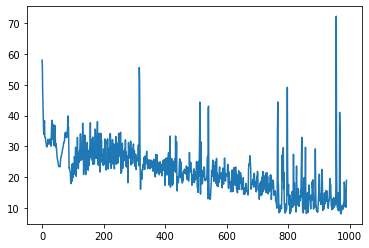

In [30]:
print(hist.history.keys())
plt.plot(hist.history['loss'][10:])

## Inferencing from trained LSTM 

CPU times: user 972 ms, sys: 95.4 ms, total: 1.07 s
Wall time: 997 ms


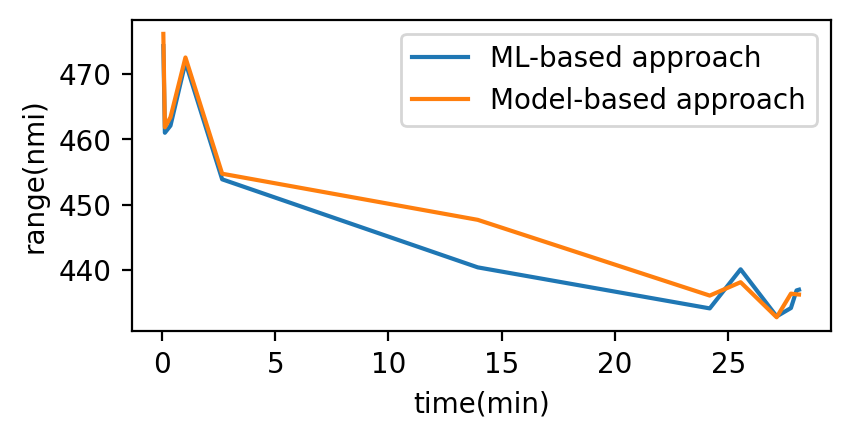

In [32]:
%%time
x_label = 'time(min)'
y_labels = ['range(nmi)', 'battery energy(kwh)', 'voltage(v)', 'current(a)']
subplot_idx = 1
fig = plt.figure(figsize=(8,4), dpi=200)
custom_fn = mape_loss_fn
key = -1
for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        model = tf.keras.models.load_model(model_dir+trained_models_name[subplot_idx-1], 
                                           custom_objects={'mape_loss_fn':custom_fn})
        
        testX, testY, key = get_data_for_lstm_inference(performance_metric, idx, key)
        
        if testX is not None:
            t = testY[:,-2]
            testX = testX.reshape((-1,1,23))
            testY = testY[:,idx].reshape((-1,1))
            outputs = model.predict(testX)
            # print(testY.shape, outputs.shape)
            y_true = testY.squeeze()
            y_pred = outputs.squeeze()

            plt.subplot(2,2,subplot_idx)
            plt.plot(t, y_pred, label='ML-based approach')
            plt.plot(t, y_true, label='Model-based approach')
            plt.xlabel(x_label)
            plt.ylabel(y_labels[subplot_idx-1])
            plt.legend()
            fig.tight_layout()
            subplot_idx += 1
        else:
            print("No valid test data found!!!")
        
# testX, testY = get_data_for_inference('aircraft_electronics')
# indxes = testY[:,-1]==1
# testX = testX[indxes]
# testY = testY[indxes]
# print(testX.shape, testY.shape)


# y_prev = np.array([[0]])

# y_true = []
# y_pred = []

# for i, x in enumerate(testX):
#     x = x.reshape((1,-1))
#     x = np.concatenate((x,y_prev), axis=1)
#     x = x.reshape((1,1,-1))
#     outputs = model.predict(x)
#     y_true.append(testY[i,3])
#     y_pred.append(outputs[0])
# #     print(y_true[i], y_pred[i])
#     y_prev[0,0] = testY[i,3] #outputs[0]
    
# plt.plot(y_true)
# plt.plot(y_pred)

# Feasibility Classifier Scores

In [524]:
for key in fesibility_result:
    fes_rslt_df = pd.DataFrame.from_dict(fesibility_result[key])
    print('**********')
    print(key)
    print(fes_rslt_df)

**********
DT
           fesibility
accuracy         0.96
f1               0.98
precision        0.97
recall           0.98
**********
ADBoost
           fesibility
accuracy         0.95
f1               0.97
precision        0.96
recall           0.97
**********
GBoost
           fesibility
accuracy         0.96
f1               0.97
precision        0.97
recall           0.98
**********
RF
           fesibility
accuracy         0.96
f1               0.98
precision        0.97
recall           0.98


# Regressor Scores

## Flight Conditions

In [525]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['flight_conditions'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0             0.0              0.00      165.13
MAE            0.0             0.0              0.01        8.20
MAPE           0.0             0.0              0.00        0.37
**********
ADBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE            0.0            0.01              0.08      183.64
MAE            0.0            0.05              0.21        9.56
MAPE           0.0            0.00              0.02        0.52
**********
GBoost
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.02            0.02              0.10      158.88
MAE           0.00            0.08              0.09        8.46
MAPE          0.00            0.00              0.01        0.57
**********
RF
      altitude(ft)  air speed(mph)  pitch angle(deg)  range(nmi)
MSE           0.06             0.0              0.16      171.75
MAE           0.00       

## Aerodynamic Coefficients 

In [526]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aerodynamic_coefficients'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       CL   CD  AOA(deg)  L/D
MSE   0.0  0.0      0.00  0.0
MAE   0.0  0.0      0.01  0.0
MAPE  0.0  0.0      0.00  0.0
**********
ADBoost
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.01  0.00
MAE   0.01  0.00      0.07  0.02
MAPE  0.01  0.01      0.01  0.00
**********
GBoost
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.10  0.00
MAE   0.01  0.00      0.14  0.03
MAPE  0.01  0.02      0.01  0.01
**********
RF
        CL    CD  AOA(deg)   L/D
MSE   0.00  0.00      0.12  0.00
MAE   0.01  0.00      0.24  0.02
MAPE  0.01  0.02      0.03  0.00


## Aircraft Electronics 

In [527]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['aircraft_electronics'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  current(a)  \
MSE   0.01                53.52               0.01       65.32        6.71   
MAE   0.04                 4.19               0.02        4.53        1.40   
MAPE  0.07                 0.07               0.00        0.01        0.01   

      C Rating instant  specific power  
MSE               0.01            0.02  
MAE               0.06            0.05  
MAPE              0.08            0.00  
**********
ADBoost
       SOC  battery energy(kwh)  battery power(kw)  voltage(v)  current(a)  \
MSE   0.01                57.61               0.00       79.31        9.29   
MAE   0.05                 4.70               0.01        5.60        1.94   
MAPE  0.08                 0.08               0.00        0.01        0.02   

      C Rating instant  specific power  
MSE               0.02            0.02  
MAE               0.08            0.03  
MAPE              0.10            0.00  
**********
GB

##  Electric motor and propeller efficiencies

In [528]:
for key in result:
    result_df = pd.DataFrame.from_dict(result[key]['electric_motor_and_propeller_efficiencies'])
    print("**********")
    print(key)
    print(result_df)

**********
DT
      propeller throttle  lift throttle  propeller thrust(N)  \
MSE                 0.02           0.00                 0.07   
MAE                 0.04           0.01                 0.06   
MAPE                0.04           0.01                 0.00   

      propeller torque(Nm)  propeller efficiency  propeller motor efficiency  \
MSE                   0.46                   0.0                         0.0   
MAE                   0.10                   0.0                         0.0   
MAPE                  0.00                   0.0                         0.0   

      propeller power coefficient  lift thrust(N)  lift torque(Nm)  \
MSE                           0.0             0.0              0.0   
MAE                           0.0             0.0              0.0   
MAPE                          0.0             0.0              0.0   

      lift efficiency  lift motor efficiency  lift power coefficient  \
MSE               0.0                    0.0           

# LSTM Scores

In [34]:
lstm_rslt_df = pd.DataFrame.from_dict(lstm_results)
print(lstm_rslt_df)

         range  battery_energy   voltage   current
MSE   4.113657        1.299014  8.389522  9.469186
MAE   0.795727        0.718257  2.135751  1.933784
MAPE  3.989269        1.023850  0.479925  1.399410


# Inferencing from the trained models

##  Flight Conditions

(45, 22) (45, 6)
Inference Time 0.08453059196472168s


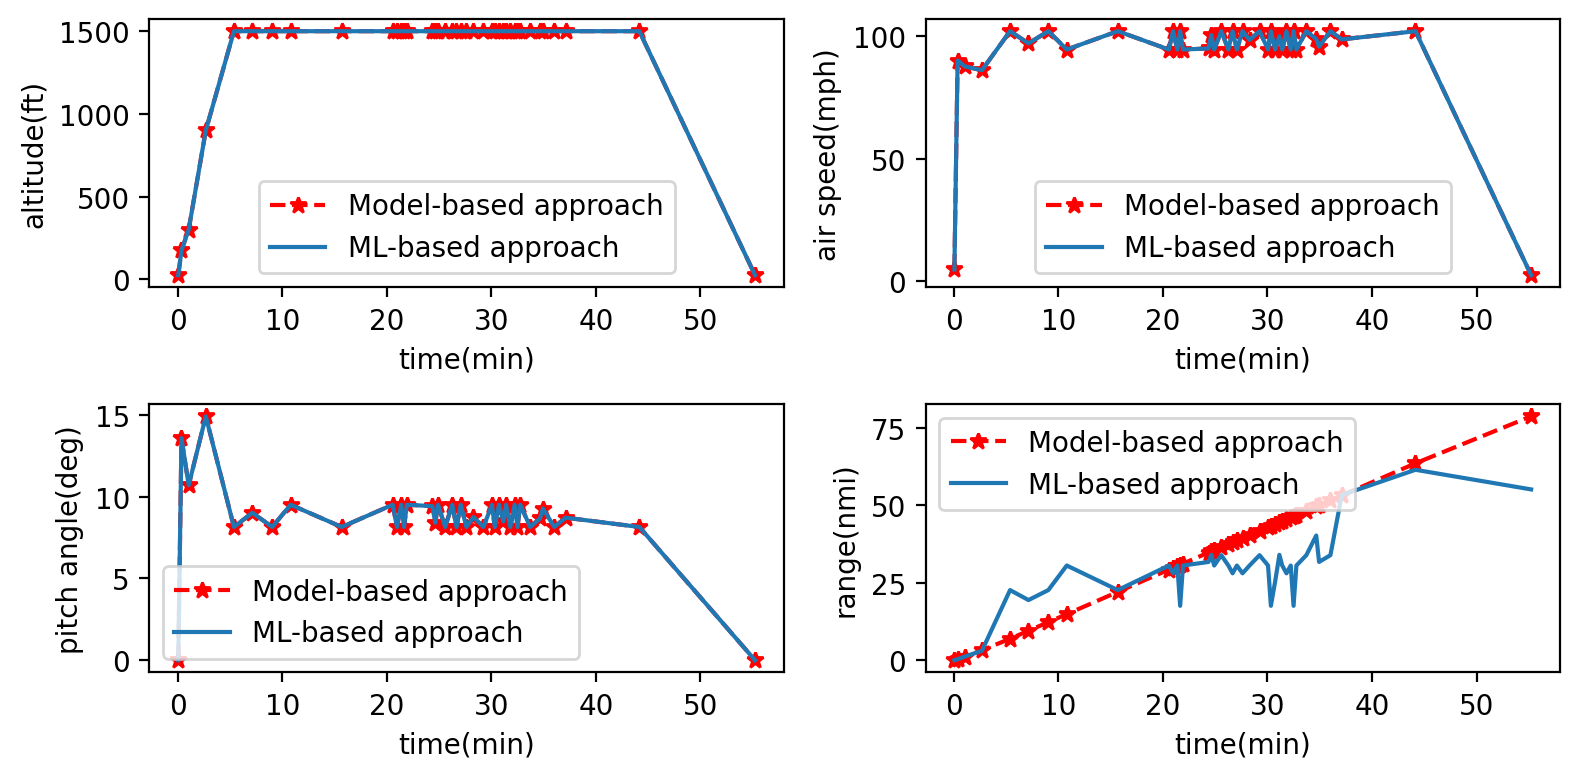

In [49]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('flight_conditions')
print(testX.shape, testY.shape)
indxes = testY[:,-1]==1
testY = testY[indxes]
testX = testX[indxes]
pred_Y = None
outputs = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
for i in [0,1,2,3]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T

x_label = 'time(min)'
y_labels = ['altitude(ft)', 'air speed(mph)', 'pitch angle(deg)', 'range(nmi)','fesibility']
t = testY[:,-2]
true_i = [0,1,2,3]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach', )
    plt.plot(t, pred_Y[:,i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout()

## Aerodynamic Coefficients 

(11, 22) (11, 6)
Inference Time 0.03185892105102539s
(11, 6) (11, 4)
CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.38 s


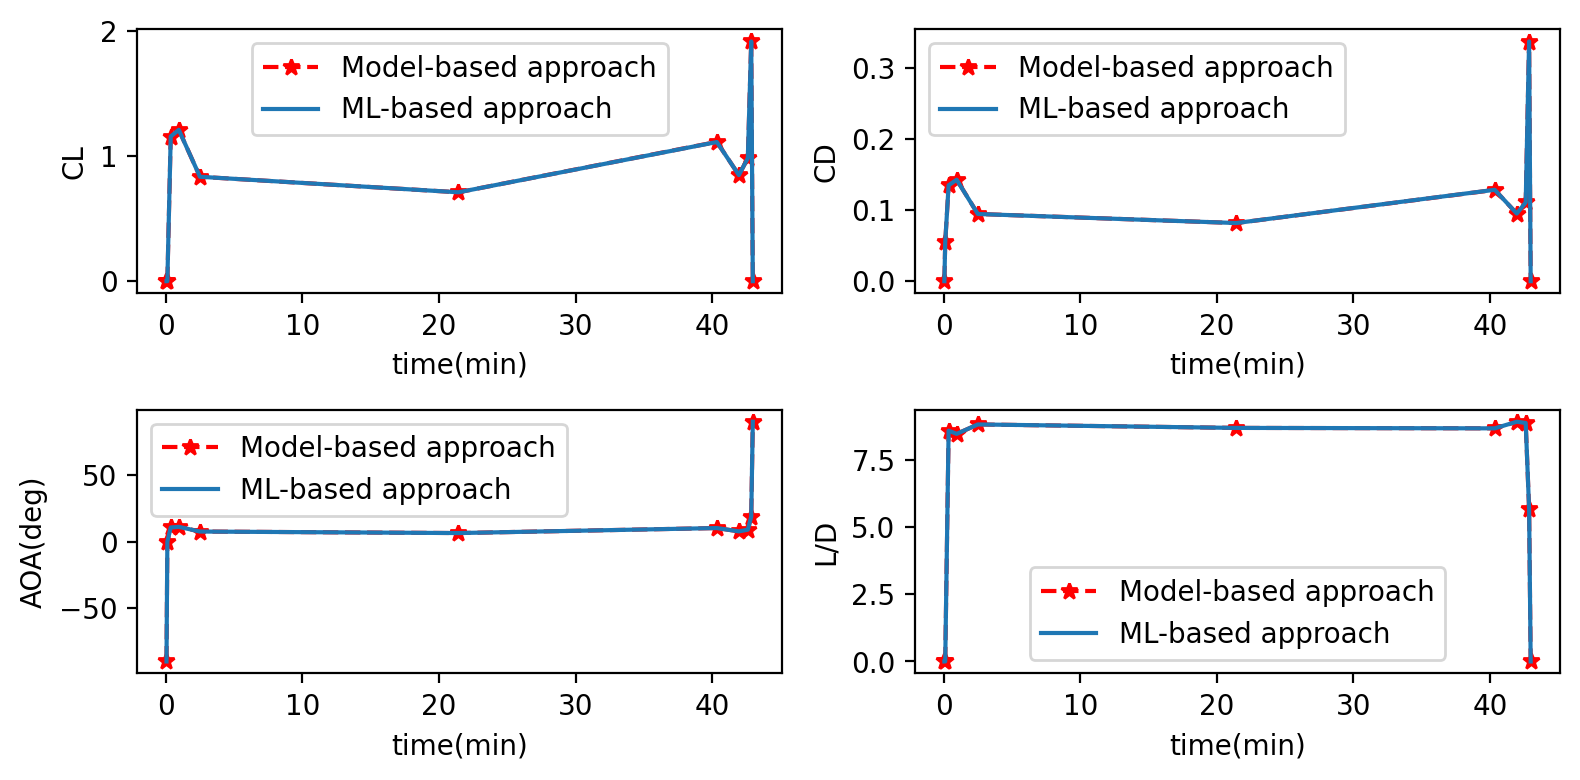

In [52]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('aerodynamic_coefficients')
print(testX.shape, testY.shape)
indxes = testY[:,-1]==1
testY = testY[indxes]
testX = testX[indxes]
pred_Y = None
outputs = ['CL', 'CD', 'AOA(deg)', 'L_D','fesibility']
for i in [0,1,2,3]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['CL', 'CD', 'AOA(deg)', 'L/D','fesibility']
t = testY[:,-2]
true_i = [0,1,2,3]
fig = plt.figure(figsize=(8,4), dpi=200)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:,i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[i-1])
    plt.legend()
fig.tight_layout() 

## Aircraft Electronics 

(12, 22) (12, 11)
Inference Time 0.19540834426879883s
(12, 11) (12, 7)
CPU times: user 564 ms, sys: 112 ms, total: 677 ms
Wall time: 453 ms


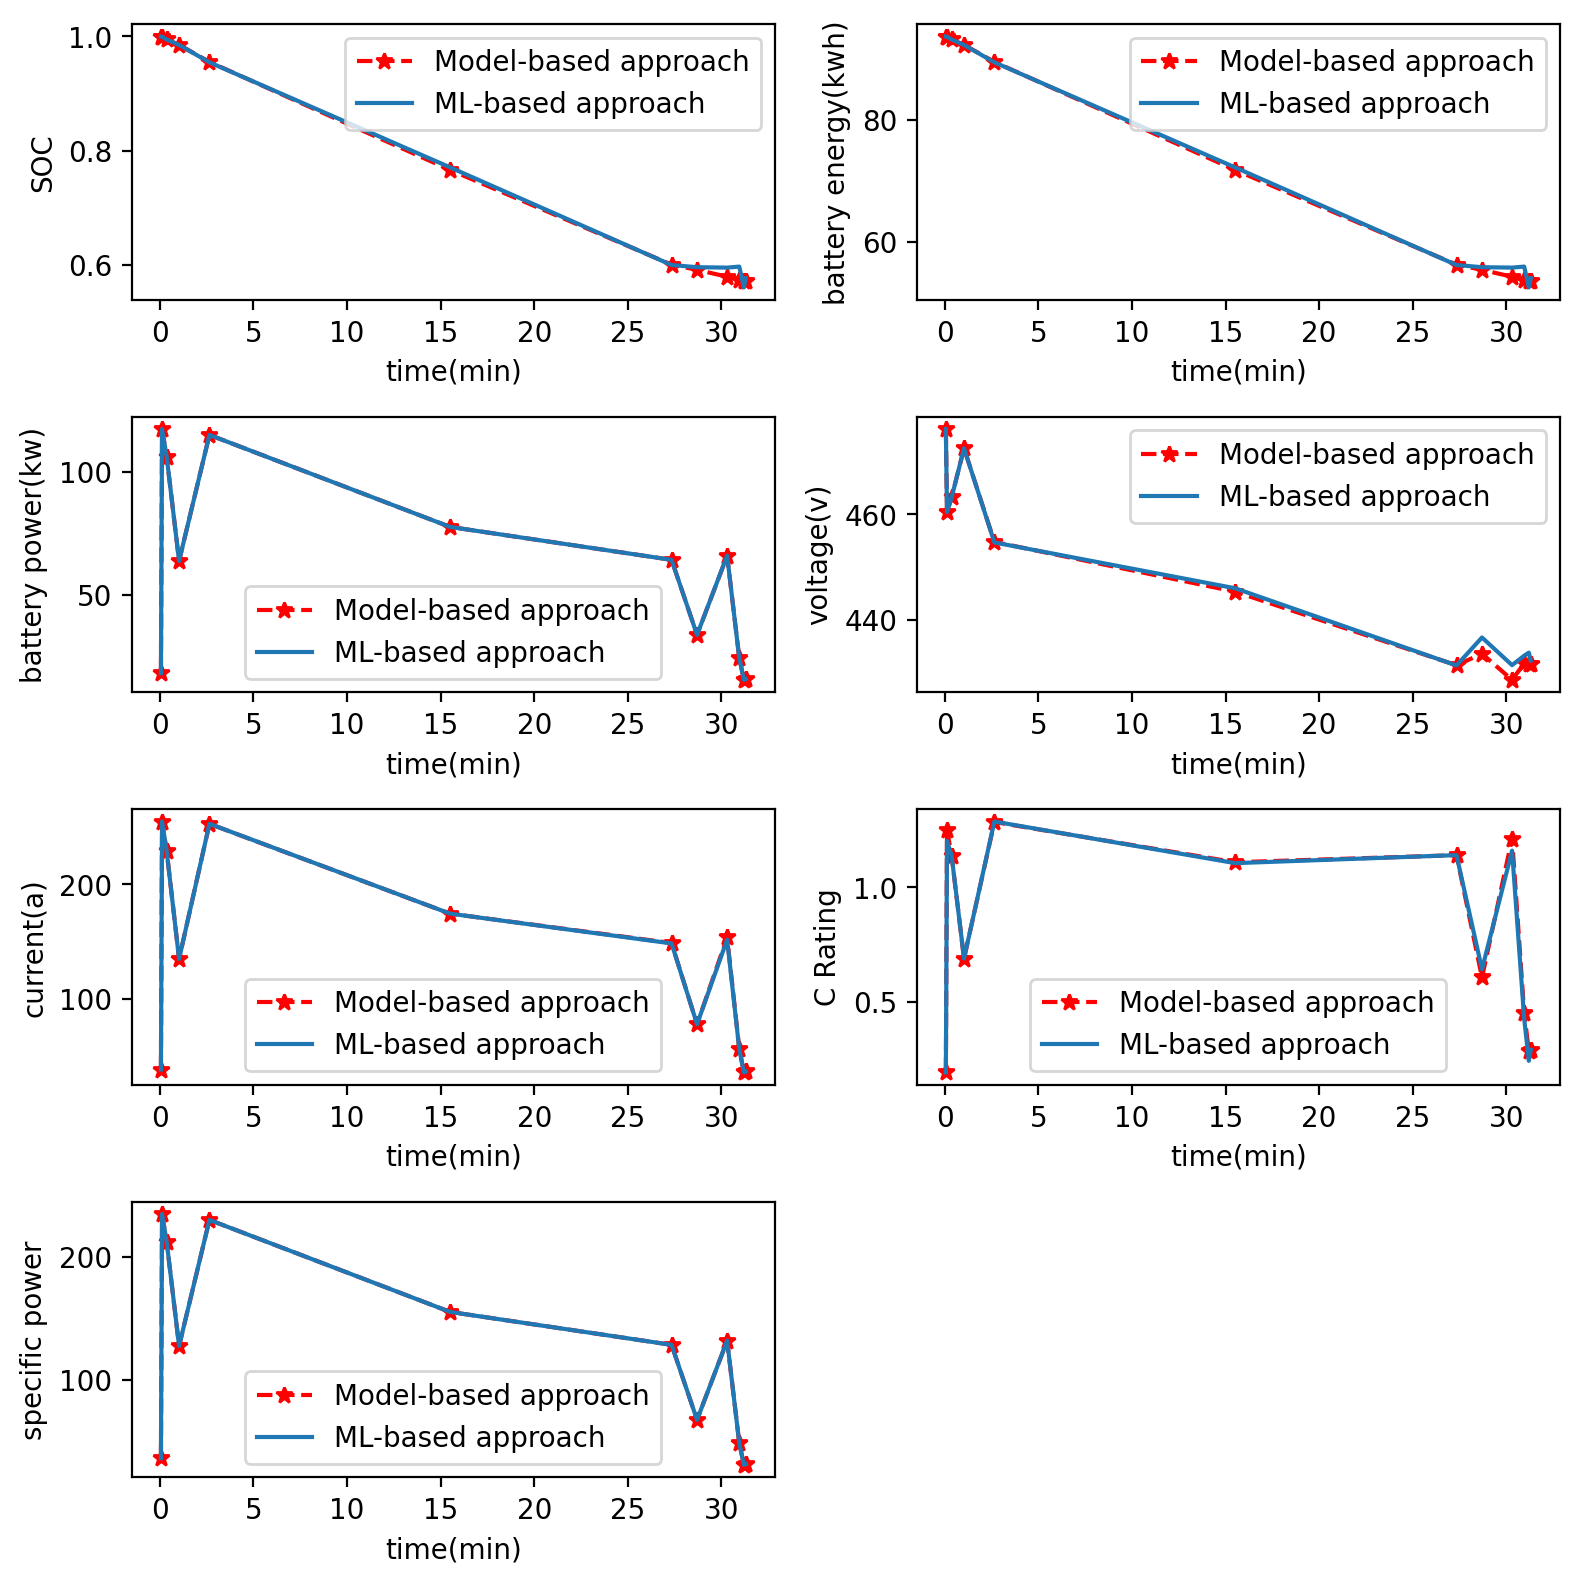

In [69]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('aircraft_electronics')
print(testX.shape, testY.shape)
indxes = testY[:,-1]==1
testY = testY[indxes]
testX = testX[indxes]
pred_Y = None
outputs = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating instant', 'C Rating nominal', 'specific power', 'fesibility']
for i in [0,1,2,3,5,6,8]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))  
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['SOC', 'battery energy(kwh)', 'battery power(kw)', 'voltage(v)', 'voltage oc(v)', 'current(a)', 
            'C Rating', 'C Rating nominal', 'specific power', 'fesibility']
t = testY[:,-2]
true_i = [0,1,2,3,5,6,8]
fig = plt.figure(figsize=(8,8), dpi=200)
for i in range(1,len(true_i)+1):
    plt.subplot(4,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:, i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[true_i[i-1]])
    plt.legend()
fig.tight_layout()

## Electric motor and propeller efficiencies 

(11, 22) (11, 18)
Inference Time 0.043543100357055664s
(11, 18) (11, 14)
CPU times: user 668 ms, sys: 172 ms, total: 839 ms
Wall time: 585 ms
Parser   : 1.44 s


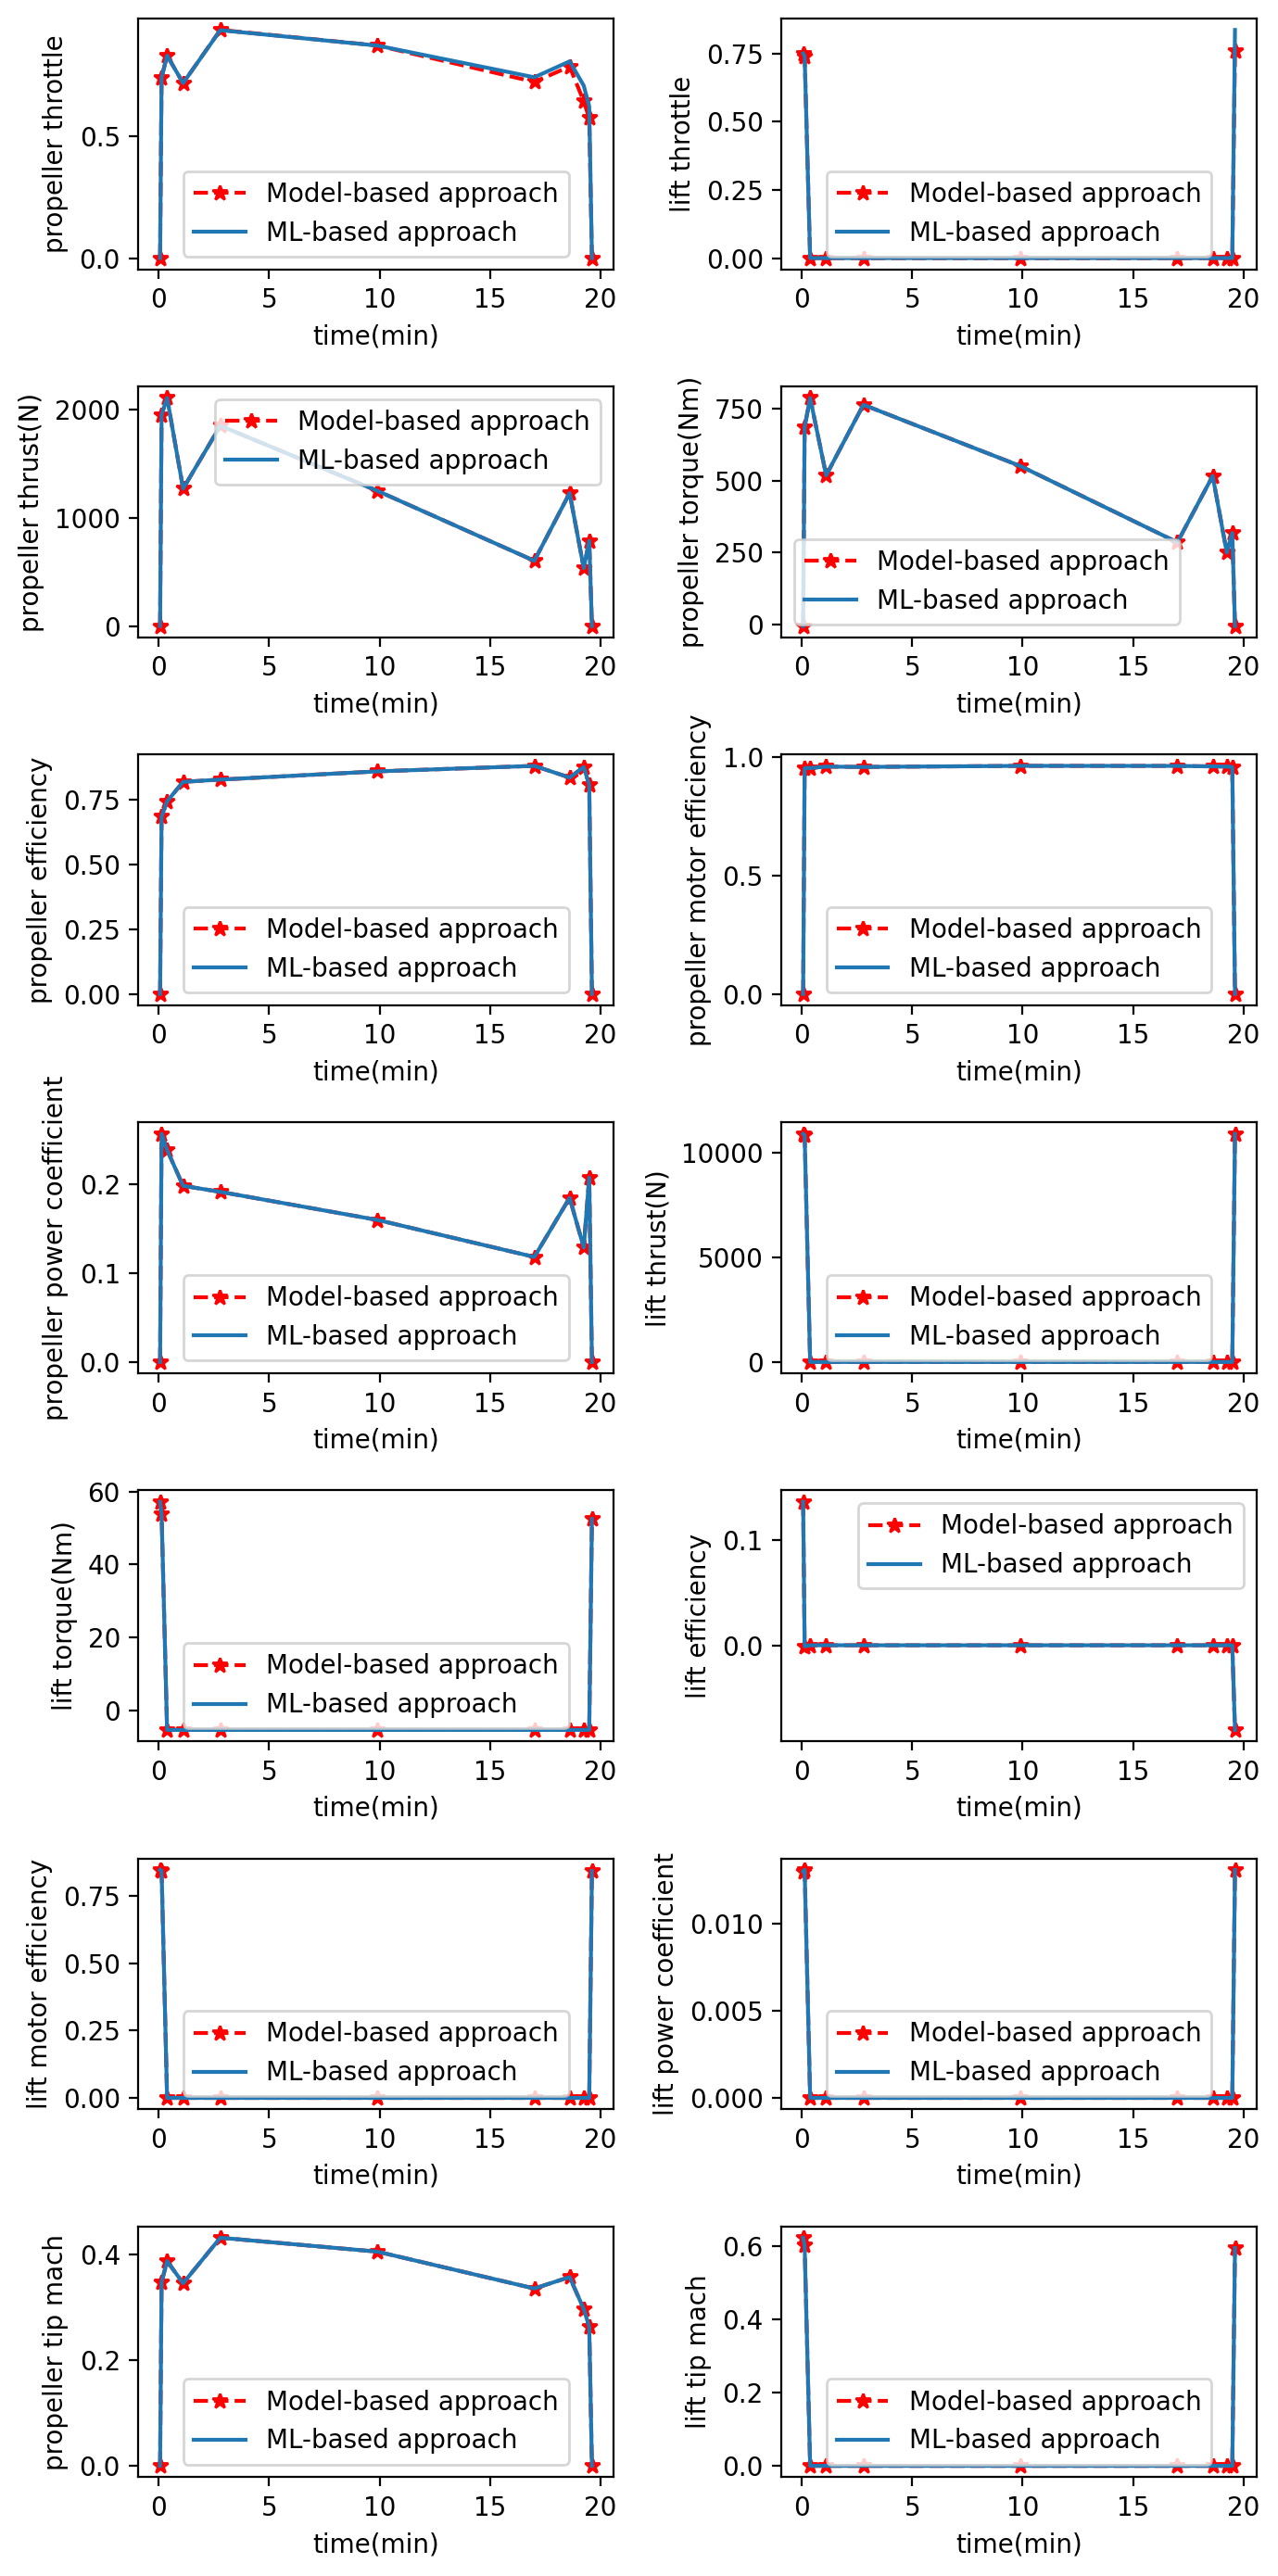

In [73]:
%%time
start_time = time.time()
testX, testY = get_data_for_inference('electric_motor_and_propeller_efficiencies')
print(testX.shape, testY.shape)
pred_Y = None
outputs = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
for i in [0,1,3,4,5,6,7,9,10,11,12,13,14,15]:
    with open('./pickle_files/'+outputs[i]+'_regr_DT.pickle', 'rb') as handle:
        estimator = pickle.load(handle)
        pred_y = estimator.predict(testX)
        pred_Y = pred_y if pred_Y is None else np.vstack((pred_Y, pred_y))
print('Inference Time {}s'.format(time.time()-start_time))
pred_Y = pred_Y.T
print(testY.shape, pred_Y.shape)
x_label = 'time(min)'
y_labels = ['propeller throttle', 'lift throttle', 'propeller rpm', 'propeller thrust(N)',
            'propeller torque(Nm)', 'propeller efficiency', 'propeller motor efficiency',
            'propeller power coefficient', 'lift rotor rpm', 'lift thrust(N)', 'lift torque(Nm)',
            'lift efficiency', 'lift motor efficiency', 'lift power coefficient', 'propeller tip mach', 
            'lift tip mach', 'fesibility']
t = testY[:,-2]
true_i = [0,1,3,4,5,6,7,9,10,11,12,13,14,15]
fig = plt.figure(figsize=(7,14), dpi=200)
for i in range(1,len(true_i)+1):
    plt.subplot(7,2,i)
    plt.plot(t, testY[:,true_i[i-1]], 'r*--', label='Model-based approach')
    plt.plot(t, pred_Y[:, i-1], label='ML-based approach')
    plt.xlabel(x_label)
    plt.ylabel(y_labels[true_i[i-1]])
    plt.legend()
fig.tight_layout()

## Inferencing from trained LSTM (range, battery energy, voltage and current)

ValueError: not enough values to unpack (expected 3, got 2)

<Figure size 1600x800 with 0 Axes>

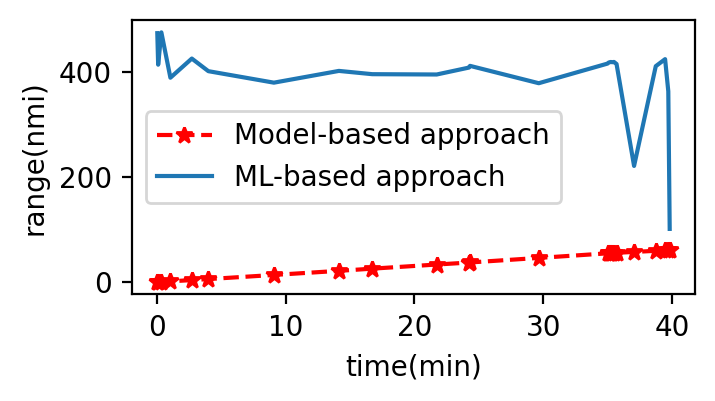

In [74]:
%%time

performance_metrics = {'flight_conditions':[3], # range
                       'aircraft_electronics':[1, 3, 5], # battery energy, voltage, current
                       }
x_label = 'time(min)'
y_labels = ['range(nmi)', 'battery energy(kwh)', 'voltage(v)', 'current(a)']
subplot_idx = 1
fig = plt.figure(figsize=(8,4), dpi=200)
custom_fn = mape_loss_fn
key = -1
fig = plt.figure(figsize=(8,4), dpi=200)
for performance_metric in performance_metrics:
    for idx in performance_metrics[performance_metric]:
        model = tf.keras.models.load_model(model_dir+trained_models_name[subplot_idx-1], 
                                           custom_objects={'mape_loss_fn':custom_fn})
        
        testX, testY, key = get_data_for_lstm_inference(performance_metric, idx, key)
        
        if testX is not None:
            t = testY[:,-2]
            testX = testX.reshape((-1,1,23))
            testY = testY[:,idx].reshape((-1,1))
            outputs = model.predict(testX)
            y_true = testY.squeeze()
            y_pred = outputs.squeeze()

            plt.subplot(2,2,subplot_idx)
            plt.plot(t, y_true, 'r*--', label='Model-based approach')
            plt.plot(t, y_pred, label='ML-based approach')
            plt.xlabel(x_label)
            plt.ylabel(y_labels[subplot_idx-1])
            plt.legend()
            subplot_idx += 1
        else:
            print("No valid test data found!!!")
fig.tight_layout()